In [1]:
from utility.RNAParser import RNAData
from utility.RNAQUBO import RNAQUBO
from utility.AnnealerOptimizer import Annealer
# from utility.ResultProcess import ResultParser
import time

timestamp = time.strftime("%Y%m%d-%H")

import numpy as np
import pandas as pd
import math
import os
import glob
import re

2022-09-27 08:01:29,672 dwave.cloud INFO MainThread Log level for 'dwave.cloud' namespace set to 0


# Step 1: Prepare Data

In this part, we load the folder with the raw rna data for experimentation. To evaluate the quantum solution and the actual solution include both fasta and ct files. To only generate a quantum solution, upload a fasta file.


In [22]:
# initial parameters for experiment data
s3_bucket = f"amazon-braket-us-east-1-002224604296" # change to the name of bucket created in your deployment
prefix = "test" # the name of the folder in the bucket

# enter folder path, for instance './rna-data'
raw_path = './rna-data'


In [3]:
rna_data = RNAData(raw_path)

data_path = rna_data.save("latest")

# print(f"You have loaded the raw rna data and saved as {data_path}. \n\
# This rna is {num_rna_length} bases long")
# #TODO inform them if it will compare or just calculate
# print()

INFO:root:finish save rna-folding_data_latest.pickle


In [4]:
rna_data.rna_files

{'bpRNA_CRW_32863': {'fasta_file': 'bpRNA_CRW_32863.fasta.txt',
  'ct_file': 'bpRNA_CRW_32863.ct.txt',
  'rna_strand': 'GCGGGUAUAGUUUAGUGGUAAAA',
  'actual_stems': [[11, 23, 6]]},
 'bpRNA_RFAM_23352': {'fasta_file': 'bpRNA_RFAM_23352.fasta.txt',
  'ct_file': 'bpRNA_RFAM_23352.ct.txt',
  'rna_strand': 'AGUGUUUUUUUCCCUCCACUUAAAUCGAAGGGU',
  'actual_stems': [[2, 19, 8], [11, 33, 11], [16, 27, 3]]},
 'bpRNA_CRW_8500': {'fasta_file': 'bpRNA_CRW_8500.fasta.txt',
  'ct_file': 'bpRNA_CRW_8500.ct.txt',
  'rna_strand': 'ACGGCGGCCAUAGCGGGGGGGUUACACCCGGUCUCAUUUCGAACCCGGAAGUUAAGCCCCCCAGCGAUCCCGGUUGUACUGCCCUCCGAGAGGGGGCGGGAAGCCGGGGACGCCGCCGGCCA',
  'actual_stems': [[3, 117, 18],
   [13, 65, 6],
   [15, 62, 18],
   [25, 53, 5],
   [28, 48, 12],
   [67, 110, 17],
   [77, 101, 19],
   [86, 93, 6]]},
 'bpRNA_RNP_17': {'fasta_file': 'bpRNA_RNP_17.fasta.txt',
  'ct_file': 'bpRNA_RNP_17.ct.txt',
  'rna_strand': 'AGGGGGCUGGUGACUAUCCACUGGGAGGAAGCUCUGCCCACCCAAUUGUGUAGAUUUCCUGAGAAGGAAUGAAUAGGGUAUAGAAACGACACGGU

After running this block, the processed data 
will be saved as **rna-folding_bpRNA_CRW_32863_data_latest.pickle**
and **data_path** will be updated. We can see that this 
molecule has 23 bases.

# Step 2: Build Model

In this part, we build the Quadratic Unconstrained 
Binary Optimization (QUBO) model for rna folding.

First, we set the following parameters and 
initialize the RNAQUBO object. 

<center>

| Parameter | Description | Value |
|--- |--- |--- |
| PKP | pseudoknot penalty | -1.0, -0.5, 0.0, 0.5, 1.0 |
| S | penalty for short stems | 1 |
| O | penalty for overlaps | 1e6 |
| method | the method of building model | 'qc' |
| data_path | pickle file directory of rna data |  |

 </center>

In [5]:
# initial the RNAQUBO object
init_param = {}
method = ['qc']

for mt in method:
    if mt == 'qc':
        init_param[mt] = {}
        init_param[mt]['params'] = ["PKP", "S", "O"]
    
rna_qubo = RNAQUBO( data_path, method, **init_param)

INFO:root:initial qc for constructing rna QUBO
INFO:root:initial qc for constructing rna QUBO
INFO:root:initial qc for constructing rna QUBO
INFO:root:initial qc for constructing rna QUBO


In [6]:
# set the parameters for model
model_param = {}

method = 'qc'
model_param[method] = {}

# parameters
model_param[method]['PKP'] = [-1.0, -0.5, 0.0, 0.5, 1.0]
model_param[method]['S'] = [1]
model_param[method]['O'] = [1e6]

rna_qubo.build_models(**model_param)

0

In [7]:
# describe the model parameters
model_info = rna_qubo.describe_models()

INFO:root:method: qc
INFO:root:The model_name should be bpRNA_CRW_32863_{PKP}_{O}_{S}
INFO:root:param: PKP, value {-0.5, 0.0, 1.0, 0.5, -1.0}
INFO:root:param: S, value {1}
INFO:root:param: O, value {1000000.0}
INFO:root:method: qc
INFO:root:The model_name should be bpRNA_RFAM_23352_{PKP}_{O}_{S}
INFO:root:param: PKP, value {-0.5, 0.0, 1.0, 0.5, -1.0}
INFO:root:param: S, value {1}
INFO:root:param: O, value {1000000.0}
INFO:root:method: qc
INFO:root:The model_name should be bpRNA_CRW_8500_{PKP}_{O}_{S}
INFO:root:param: PKP, value {-0.5, 0.0, 1.0, 0.5, -1.0}
INFO:root:param: S, value {1}
INFO:root:param: O, value {1000000.0}
INFO:root:method: qc
INFO:root:The model_name should be bpRNA_RNP_17_{PKP}_{O}_{S}
INFO:root:param: PKP, value {-0.5, 0.0, 1.0, 0.5, -1.0}
INFO:root:param: S, value {1}
INFO:root:param: O, value {1000000.0}


In [8]:
# save the model
model_path = rna_qubo.save("latest")

print(f"You have built the QUBO models and saved them as rna_folding_latest.pickle")

INFO:root:finish save rna_folding_latest.pickle


You have built the QUBO models and saved them as rna_folding_latest.pickle


In [12]:
# !mv rna_folding_latest.pickle rna-data/

# Step 3: Optimize Configuration

In this part, we use SA and QA to find the optimized configuration of rna folding.
At first, we load the model file using **RNAQUBO** object

In [9]:
rna_qubo_optimize = RNAQUBO.load(model_path)

In [10]:
model_info = rna_qubo_optimize.describe_models()

INFO:root:method: qc
INFO:root:The model_name should be bpRNA_CRW_32863_{PKP}_{O}_{S}
INFO:root:param: PKP, value {-0.5, 0.0, 1.0, 0.5, -1.0}
INFO:root:param: S, value {1}
INFO:root:param: O, value {1000000.0}
INFO:root:method: qc
INFO:root:The model_name should be bpRNA_RFAM_23352_{PKP}_{O}_{S}
INFO:root:param: PKP, value {-0.5, 0.0, 1.0, 0.5, -1.0}
INFO:root:param: S, value {1}
INFO:root:param: O, value {1000000.0}
INFO:root:method: qc
INFO:root:The model_name should be bpRNA_CRW_8500_{PKP}_{O}_{S}
INFO:root:param: PKP, value {-0.5, 0.0, 1.0, 0.5, -1.0}
INFO:root:param: S, value {1}
INFO:root:param: O, value {1000000.0}
INFO:root:method: qc
INFO:root:The model_name should be bpRNA_RNP_17_{PKP}_{O}_{S}
INFO:root:param: PKP, value {-0.5, 0.0, 1.0, 0.5, -1.0}
INFO:root:param: S, value {1}
INFO:root:param: O, value {1000000.0}


In [11]:
# get the model you want to optimize
rna_name = 'bpRNA_CRW_32863'
PKP = 0.5
O = 1e6
S = 1
method = 'qc'

model_name = "{}_{}_{}_{}".format(rna_name, PKP, O, S)

qubo_model = rna_qubo_optimize.get_model(rna_name, method, model_name)

After we get the qubo model, we need to set the parameters for optimization: 
| Parameter | Description | Value |
|--- |--- |--- |
|method | annealing method for QUBO problem |'dwave-sa': use the simulated annealer in ocean toolkit<br> 'dwave-qa': use the quantum annealer|
|shots| number of reads, refer to [dwave-sa](https://docs.ocean.dwavesys.com/projects/neal/en/latest/reference/generated/neal.sampler.SimulatedAnnealingSampler.sample.html#neal.sampler.SimulatedAnnealingSampler.sample) and [dwave-qa](https://amazon-braket-ocean-plugin-python.readthedocs.io/en/latest/_apidoc/braket.ocean_plugin.braket_sampler.html) for details |1 to 10,000|
|bucket | the s3 bucket to store your results | - |
|prefix | the name of the folder in your s3 bucket | - |
|device | the arn name to run your quantum annealing| 'arn:aws:braket:::device/qpu/d-wave/Advantage_system4' <br> 'arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6'|

Then, we can run the SA for this problem:

In [12]:
method = 'neal-sa'

optimizer_param = {}
optimizer_param['shots'] = 1000

sa_optimizer = Annealer(qubo_model, method, **optimizer_param)

INFO:root:use neal simulated annealer (c++) from dimod


In [13]:
sa_optimize_result = sa_optimizer.fit()

INFO:root:fit() ...
INFO:root:neal-sa save to local
INFO:root:finish save neal-sa_result.pickle


In [16]:
method = 'dwave-qa'

optimizer_param = {}
optimizer_param['shots'] = 1000
optimizer_param['bucket'] = s3_bucket # the name of the bucket
optimizer_param['prefix'] = prefix # the name of the folder in the bucket
optimizer_param['device'] = "arn:aws:braket:::device/qpu/d-wave/Advantage_system4"
optimizer_param["embed_method"] = "default"

qa_optimizer = Annealer(qubo_model, method, **optimizer_param)

INFO:root:use quantum annealer arn:aws:braket:::device/qpu/d-wave/Advantage_system4 


In [17]:
# not create annealing task, only embedding logic
qa_optimizer.embed()
# create annealing task
qa_optimize_result = qa_optimizer.fit()

INFO:root:fit() ...
INFO:root:finish save /tmp/qa_result.pickle
INFO:root:_upload_result_json, bucket=amazon-braket-us-east-1-002224604296, key=test/60c076ab-7a85-4816-b861-4c0d193b3125/qa_result.pickle
INFO:root:dwave-qa save to s3 - 60c076ab-7a85-4816-b861-4c0d193b3125: None


In [18]:
qa_task_id = qa_optimizer.get_task_id()
print(f"task id is {qa_task_id}")

task id is 60c076ab-7a85-4816-b861-4c0d193b3125


In [19]:
print(f"dwave-sa run time {sa_optimize_result['time']}")
print(f"dwave-qa run time {qa_optimize_result['time']}")

dwave-sa run time 0.1650984287261963
dwave-qa run time 8.220567226409912


# Step 4: Optimize Configuration

In this part, we post process the optimizing results for evaluation and visualization.
At first, we prepare the following parameters:

| Parameter | Description | Value |
|--- |--- |--- |
|method | annealing method for QUBO problem |'dwave-sa': use the simulated annealer in ocean toolkit<br> 'dwave-qa': use the quantum annealer|
|raw_path| the path for the original molecule file| './molecule-data/117_ideal.mol2' in this example |
|data_path| the path for the processed molecule file| './qmu_117_ideal_data_latest.mol2' in this example |
|bucket | the s3 bucket to store your results | - |
|prefix | the name of the folder in your s3 bucket | - |
|task_id | the id for your quantum annealing task| '2b5a3b05-1a0e-443a-852c-4ec422a10e59' in this example |

In [8]:
from utility.RNAParser import RNAData
from utility.RNAQUBO import RNAQUBO
from utility.AnnealerOptimizer import Annealer
from utility.ResultProcess import ResultParser
import time

timestamp = time.strftime("%Y%m%d-%H")

import numpy as np
import pandas as pd
import math
import os
import glob
import re

# initial parameters for experiment data
s3_bucket = f"amazon-braket-us-east-1-002224604296" # change to the name of bucket created in your deployment
prefix = "test" # the name of the folder in the bucket

In [9]:
data_path = './rna-folding_data_latest.pickle'
raw_path = './rna-data'
rna_name = 'bpRNA_CRW_32863'

In [10]:
method = "neal-sa"
sa_param = {}
sa_param["raw_path"] = raw_path
sa_param["data_path"] = data_path
sa_param["data_name"] = rna_name

sa_process_result = ResultParser(method, **sa_param)
# print(f"{method} result is {sa_process_result.get_all_result()}")

local_time, _ , _, _= sa_process_result.get_time()

print(f"time for {method}: \n \
    local time is {local_time}")

INFO:root:_load_raw_result
INFO:root:load simulated annealer neal-sa raw result
INFO:root:Data.load()
INFO:root:parse simulated annealer result
INFO:root:sa only has local_time!


time for neal-sa: 
     local time is 0.1650984287261963


In [11]:
sa_process_result.raw_result.keys()

dict_keys(['response', 'time', 'model_info'])

In [12]:
sa_process_result.rna_data

In [13]:
sa_process_result.rna_data.rna_files[rna_name]

{'fasta_file': 'bpRNA_CRW_32863.fasta.txt',
 'ct_file': 'bpRNA_CRW_32863.ct.txt',
 'rna_strand': 'GCGGGUAUAGUUUAGUGGUAAAA',
 'actual_stems': [[11, 23, 6]]}

In [7]:
sa_atom_pos_data = sa_process_result.generate_optimize_pts()
# save unfold file for visualization and parameters for experiment: 1. volume value 2. relative improvement
sa_result_filepath, sa_result_json = sa_process_result.save_mol_file(f"{timestamp}")

print(f"result path is {sa_result_filepath}, and result optimization file path is {sa_result_json}")

INFO:root:generate_optimize_pts()
INFO:root:generate_optimize_pts model_info={'model_name': 'bpRNA_CRW_32863_0.5_1000000.0_1'}
INFO:root:candidate result is 0                    0.0
1                    0.0
10                   0.0
11                   0.0
12                   0.0
2                    0.0
3                    1.0
4                    0.0
5                    0.0
6                    0.0
7                    0.0
8                    0.0
9                    1.0
energy            -144.0
num_occurrences    363.0
Name: 0, dtype: float64


stem found!
stem found!


KeyError: '13'

In [ ]:
sa_process_result.parameters

In [ ]:
method = "dwave-qa"
qa_param = {}
qa_param["bucket"] = s3_bucket
qa_param["prefix"] = prefix
qa_param["task_id"] = qa_task_id
qa_param["raw_path"] = raw_path
qa_param["data_path"] = data_path

qa_process_result = ResultParser(method, **qa_param)
# print(f"{method} result is {qa_process_result.get_all_result()}")

local_time, task_time, total_time, access_time = qa_process_result.get_time()

print(f"time for {method}: \n \
    local time is {local_time},\n \
    task time is {task_time}, \n \
    qpu total time is {total_time}, \n \
    qpu access time is {access_time}")

In [ ]:
# this shows the original molecule
sa_process_result.InteractView(raw_path, size=800)

In [2]:
import matplotlib.pyplot as plt
import forgi.visual.mplotlib as fvm
import forgi.graph.bulge_graph as fgb
import forgi 

In [1]:
def parse_pseudoknot(ctList):
    """
    ctList              -- paired-bases: [(3, 8), (4, 7)]
    
    Parse pseusoknots from clList
    Return:
        [ [(3, 8), (4, 7)], [(3, 8), (4, 7)], ... ]
    """
    ctList.sort(key=lambda x:x[0])
    ctList = [ it for it in ctList if it[0]<it[1] ]
    paired_bases = set()
    for lb,rb in ctList:
        paired_bases.add(lb)
        paired_bases.add(rb)
    
    # Collect duplex
    duplex = []
    cur_duplex = [ ctList[0] ]
    for i in range(1, len(ctList)):
        bulge_paired = False
        for li in range(ctList[i-1][0]+1, ctList[i][0]):
            if li in paired_bases:
                bulge_paired = True
                break
        if ctList[i][1]+1>ctList[i-1][1]:
            bulge_paired = True
        else:
            for ri in range(ctList[i][1]+1, ctList[i-1][1]):
                if ri in paired_bases:
                    bulge_paired = True
                    break
        if bulge_paired:
            duplex.append(cur_duplex)
            cur_duplex = [ ctList[i] ]
        else:
            cur_duplex.append(ctList[i])
    if cur_duplex:
        duplex.append(cur_duplex)
    
    # Discriminate duplex are pseudoknot
    Len = len(duplex)
    incompatible_duplex = []
    for i in range(Len):
        for j in range(i+1, Len):
            bp1 = duplex[i][0]
            bp2 = duplex[j][0]
            if bp1[0]<bp2[0]<bp1[1]<bp2[1] or bp2[0]<bp1[0]<bp2[1]<bp1[1]:
                incompatible_duplex.append((i, j))
    
    pseudo_found = []
    while incompatible_duplex:
        # count pseudo
        count = {}
        for l,r in incompatible_duplex:
            count[l] = count.get(l,0)+1
            count[r] = count.get(r,0)+1
        
        # find most possible pseudo
        count = list(count.items())
        count.sort( key=lambda x: (x[1],-len(duplex[x[0]])) )
        possible_pseudo = count[-1][0]
        pseudo_found.append(possible_pseudo)
        i = 0
        while i<len(incompatible_duplex):
            l,r = incompatible_duplex[i]
            if possible_pseudo in (l,r):
                del incompatible_duplex[i]
            else:
                i += 1
    
    pseudo_duplex = []
    for i in pseudo_found:
        pseudo_duplex.append(duplex[i])
    
    return pseudo_duplex

In [2]:
def ct2dot(ctList, length):
    """
    ctList              -- paired-bases: [(3, 8), (4, 7)]
    length              -- Length of structure
    
    Convert ctlist structure to dot-bracket
    [(3, 8), (4, 7)]  => ..((..))..
    """
    dot = ['.']*length
    if len(ctList) == 0:
        return "".join(dot)
    ctList = sorted(ctList, key=lambda x:x[0])
    ctList = [ it for it in ctList if it[0]<it[1] ]
    pseudo_duplex = parse_pseudoknot(ctList)
    for l,r in ctList:
        dot[l-1] = '('
        dot[r-1] = ')'
    dottypes = [ '<>', r'{}', '[]' ]
    if len(pseudo_duplex)>len(dottypes):
        print("Warning: too many psudoknot type: %s>%s" % (len(pseudo_duplex),len(dottypes)))
    for i,duplex in enumerate(pseudo_duplex):
        for l,r in duplex:
            dot[l-1] = dottypes[i%3][0]
            dot[r-1] = dottypes[i%3][1]
    return "".join(dot)

In [9]:
ct2dot([(3,8),(4,7)],10)

'..((..))..'

In [73]:
with open('./rna-data/bpRNA_RNP_17.ct.txt') as file:
    lines = file.readlines()
    
with open('./rna-data/bpRNA_RNP_17.fasta.txt') as file:
    fasta_lines = file.readlines()
    
    
rna = fasta_lines[1]
    
stems_actual = []

sip = False                       # stem in progress?
sl = 0                            # stem length
last_line = [0, 0, 0, 0, 0, 0]    # initiate last line

base_pair = []

for i in range(0, len(lines)):
    line = lines[i].strip().split()
    # print(line)
    
    if (int(line[4]) != 0 and sip == False):
        sip = True
        temp = [int(line[0]), int(line[4])]
        temp_base = [(int(line[0]), int(line[4]))]
        # print(f"temp is {temp}")
        if (rna[i] == ('G' or 'g') and rna[int(line[4])-1] == ('C' or 'c')) or (rna[i] == ('C' or 'c') and rna[int(line[4])-1] == ('G' or 'g')):
            sl += 3
        if (rna[i] == ('G' or 'g') and rna[int(line[4])-1] == ('U' or 'u')) or (rna[i] == ('U' or 'u') and rna[int(line[4])-1] == ('G' or 'g')) or (rna[i] == ('A' or 'a') and rna[int(line[4])-1] == ('U' or 'u')) or (rna[i] == ('U' or 'u') and rna[int(line[4])-1] == ('A' or 'a')):
            sl += 2
    if (int(line[4]) != 0 and sip == True and (int(last_line[4])-int(line[4]) == 1)):
        temp_base.append((int(line[0]), int(line[4])))
        if (rna[i] == ('G' or 'g') and rna[int(line[4])-1] == ('C' or 'c')) or (rna[i] == ('C' or 'c') and rna[int(line[4])-1] == ('G' or 'g')):
            sl += 3
        if (rna[i] == ('G' or 'g') and rna[int(line[4])-1] == ('U' or 'u')) or (rna[i] == ('U' or 'u') and rna[int(line[4])-1] == ('G' or 'g')) or (rna[i] == ('A' or 'a') and rna[int(line[4])-1] == ('U' or 'u')) or (rna[i] == ('U' or 'u') and rna[int(line[4])-1] == ('A' or 'a')):
            sl += 2
    if (int(line[4]) == 0 and sip == True):
        sip = False
        temp.append(sl)
        if temp[1] > temp[0]:
            stems_actual.append(temp)
            base_pair = base_pair + temp_base
        sl = 0
    if ((int(last_line[4])-int(line[4]) != 1) and int(last_line[4]) != 0  and sip == True):
        temp.append(sl)
        if temp[1] > temp[0]:
            stems_actual.append(temp)
            base_pair = base_pair + temp_base
        temp = [int(line[0]), int(line[4])]
        temp_base = [(int(line[0]), int(line[4]))]
        sl = 0
        if (rna[i] == ('G' or 'g') and rna[int(line[4])-1] == ('C' or 'c')) or (rna[i] == ('C' or 'c') and rna[int(line[4])-1] == ('G' or 'g')):
            sl = 3
        if (rna[i] == ('G' or 'g') and rna[int(line[4])-1] == ('U' or 'u')) or (rna[i] == ('U' or 'u') and rna[int(line[4])-1] == ('G' or 'g')) or (rna[i] == ('A' or 'a') and rna[int(line[4])-1] == ('U' or 'u')) or (rna[i] == ('U' or 'u') and rna[int(line[4])-1] == ('A' or 'a')):
            sl = 2

    last_line = line

In [74]:
rna

'AGGGGGCUGGUGACUAUCCACUGGGAGGAAGCUCUGCCCACCCAAUUGUGUAGAUUUCCUGAGAAGGAAUGAAUAGGGUAUAGAAACGACACGGUUCUAAGAAAUAUGACUAUGAUAUUUUCAAAAUUGAGGAUUCUUAGAAAAUCGAUGAAACGACCUUAUUUUACACGGGUGCAAGCAUAUGUGCUAAGCUGAAUGUCACCGAAAUUACAGAAGGCAGGCUAUAGCCCCCA'

In [72]:
base_pair

[(2, 19),
 (3, 18),
 (4, 17),
 (11, 33),
 (12, 32),
 (13, 31),
 (14, 30),
 (15, 29),
 (16, 27)]

In [75]:
rna_len = len(lines)

In [76]:
dc = ct2dot(base_pair, rna_len)

In [77]:
import matplotlib.pyplot as plt
import forgi.visual.mplotlib as fvm
import forgi.graph.bulge_graph as fgb
import forgi

In [78]:
file_name = "rna-data/test.fx"
file_lines = []
file_lines.append('>test')
file_lines.append(rna)
file_lines.append(dc)

f = open(file_name, "w")

for line in file_lines:
    f.write(line + '\n')
    
f.close()

In [63]:
!cat rna-data/test.fx

>test
GCGGGUAUAGUUUAGUGGUAAAA
..........(((.......)))


In [26]:
!cat rna-data/1y26.fx

>1y26
CGCUUCAUAUAAUCCUAAUGAUAUGGUUUGGGAGUUUCUACCAAGAGCCUUAAACUCUUGAUUAUGAAGUG
((((((((((..(((((((.......)))))))......).((((((.......))))))..)))))))))


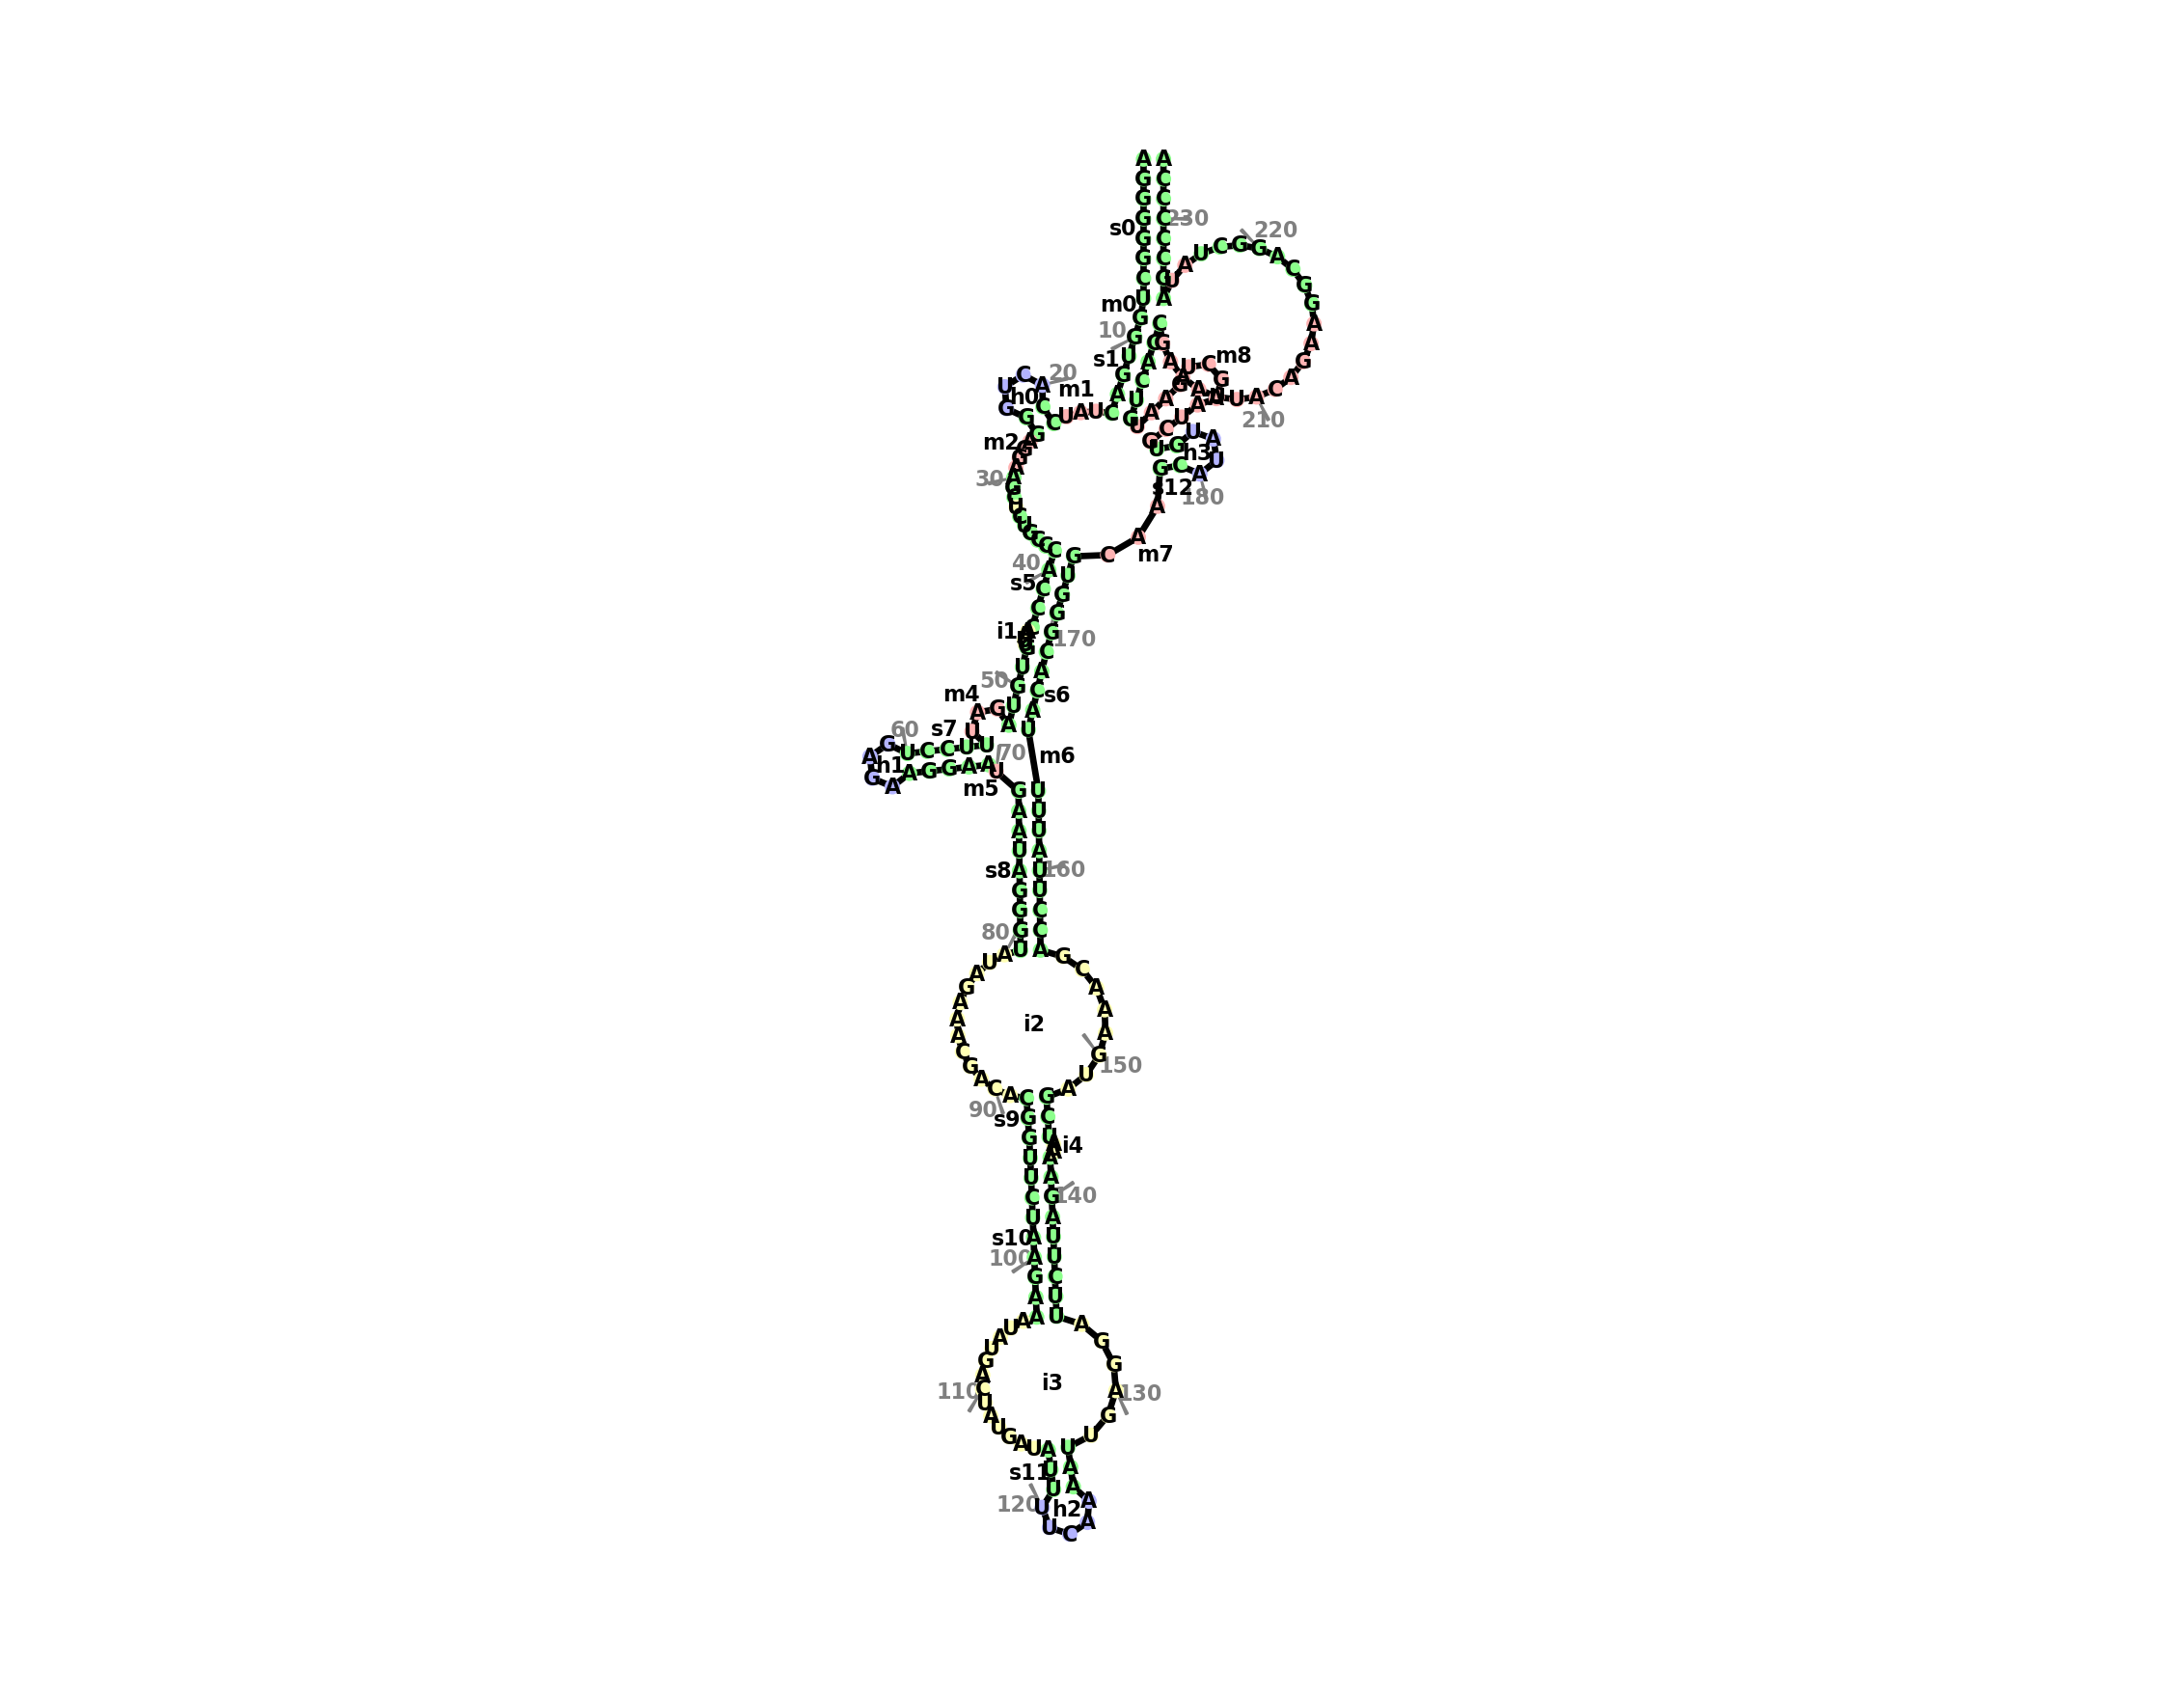

In [79]:
from matplotlib.pyplot import figure

figure(figsize=(18, 14), dpi=160)

bg = forgi.load_rna("rna-data/test.fx", allow_many=False)
# bg = forgi.load_rna("rna-data/test.fx")

ax,_ = fvm.plot_rna(bg, text_kwargs={"fontweight":"black"}, lighten=0.7,
             backbone_kwargs={"linewidth":3})
plt.show()